First load the Crab count rates file, which was acquired in CrabLongTerm.ipynb

In [18]:
import numpy as np

input_filename = "../data/crab_countrate_data.txt"

data = np.genfromtxt(input_filename, delimiter=",", dtype=None, names=True, encoding=None)

obs_start_dates = data["Obs_Start_Date"]
obs_end_dates = data["Obs_End_Date"]
crab_countrates = data["Count_Rate"]
crab_variances = data["Variance"]
offsets = data["Angular_offset"]


Do some plotting

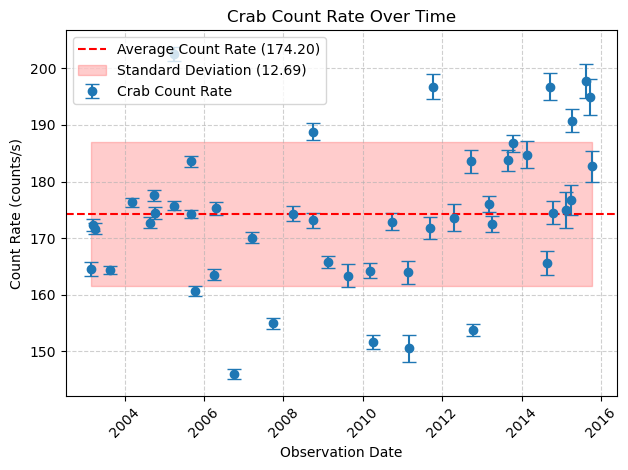

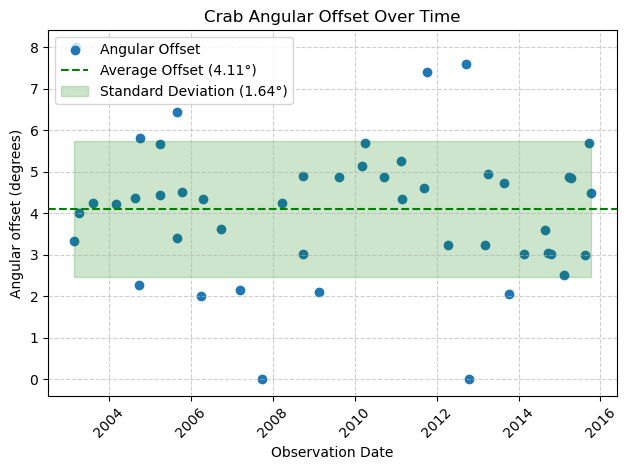

In [20]:
from datetime import datetime
import matplotlib.pyplot as plt

obs_times = [datetime.strptime(date, "%Y-%m-%dT%H:%M:%S") for date in obs_start_dates]

crab_countrates = np.array(crab_countrates)
crab_variances = np.array(crab_variances)
errors = np.sqrt(crab_variances)
offsets = np.array(offsets)

# Calculate average and standard deviation
avg_count_rate = np.mean(crab_countrates)
std_count_rate = np.std(crab_countrates)

avg_offset = np.mean(offsets)
std_offset = np.std(offsets)

# Plot count rate over time with errorbars and std region
plt.figure()
plt.errorbar(obs_times, crab_countrates, yerr=errors, fmt='o', capsize=5, label='Crab Count Rate')
plt.axhline(avg_count_rate, color='r', linestyle='--', label=f'Average Count Rate ({avg_count_rate:.2f})')
plt.fill_between(obs_times, avg_count_rate - std_count_rate, avg_count_rate + std_count_rate, color='r', alpha=0.2, label=f'Standard Deviation ({std_count_rate:.2f})')
plt.xlabel("Observation Date")
plt.ylabel("Count Rate (counts/s)")
plt.title("Crab Count Rate Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()

# Plot angular offset from pointing center over time with std region
plt.figure()
plt.scatter(obs_times, offsets, label='Angular Offset')
plt.axhline(avg_offset, color='g', linestyle='--', label=f'Average Offset ({avg_offset:.2f}°)')
plt.fill_between(obs_times, avg_offset - std_offset, avg_offset + std_offset, color='g', alpha=0.2, label=f'Standard Deviation ({std_offset:.2f}°)')
plt.xlabel("Observation Date")
plt.ylabel("Angular offset (degrees)")
plt.title("Crab Angular Offset Over Time")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
